In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
import numpy as np
import pickle
import sklearn 
import imblearn
import xgboost
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import joblib

In [18]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The xgboost version is {}.'.format(xgboost.__version__))

The scikit-learn version is 1.1.3.
The xgboost version is 1.7.3.


In [19]:
data = pd.read_csv('data/fraudTest.csv', index_col=0)

In [20]:
data.shape

(555719, 22)

In [21]:
data.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [22]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [23]:
data.columns.values

array(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'], dtype=object)

In [24]:
labels=["Genuine","Fraud"]

fraud_or_not = data["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=data['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["LightGreen","Blue"]
             ,title="Fraud vs Genuine transactions")
fig.show()

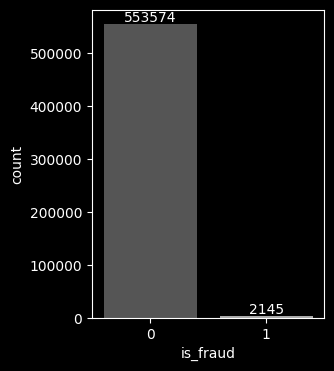

In [25]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='is_fraud',data=data,palette="gray")
for i in ax.containers:
    ax.bar_label(i,)

we have 99,6% of Genuine transactions and only 0,386%of fraud transactions

We can not use accuracy as score because of imbalanced data! Better to use F1-score or other metrics!

## Data pre-processing

In [26]:
# Drop duplicates lines : 
data.drop_duplicates(inplace=True)
data.shape

(555719, 22)

### Under-sampling Data to get balanced Dataset
 

In [27]:
# define dataset
X, y = make_classification(n_samples=100000, weights=[0.99], flip_y=0)

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [28]:
# define pipeline
steps = [('under', undersample), ('model', XGBClassifier())]
pipeline = Pipeline(steps=steps)

# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

print(Counter(y))
print(Counter(y_under))

Counter({0: 99000, 1: 1000})
Counter({0: 2000, 1: 1000})


In [29]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

F1 Score: 0.962


In [33]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "is_fraud"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X : ')
print(X.head())

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)


Separating labels from features...
...Done.

Y : 
0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

X : 
  trans_date_trans_time            cc_num  \
0   2020-06-21 12:14:25  2291163933867244   
1   2020-06-21 12:14:33  3573030041201292   
2   2020-06-21 12:14:53  3598215285024754   
3   2020-06-21 12:15:15  3591919803438423   
4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street        city  ...    zip  \
0   Elliott      M            351 Darlene Green    Columbia  ...  29209   
1  Williams   

/var/folders/5q/4k55d_7j1kq3rt9wy30qwsk40000gn/T/ipykernel_22529/1880511398.py:20: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [34]:
numeric_features = ['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
categorical_features = ['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']

In [36]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [37]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [38]:
from sklearn.model_selection import train_test_split
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, stratify=y_under, test_size = 0.2)

Dividing into train and test sets...


In [42]:
model = Pipeline(steps=[("Preprocessing", preprocessor),
        ("Classifier",XGBClassifier())
    ])

In [43]:
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print("f1-score on train set : ", f1_score(y_train, train_pred))
print("f1-score on test set : ", f1_score(y_test, test_pred))

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

## Preparing the API

In [ ]:
from joblib import dump, load
dump(model, 'model_xg.joblib')

['model_xg.joblib']

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk


In [ ]:
# model.save_model("model_xgb.json")
# model_xgb_2 = xgb.Booster()
# model_xgb_2.load_model("model.json")


In [ ]:
predictionFeatures = { }

In [ ]:
data = pd.DataFrame(dict(predictionFeatures), index=[0])
data

""
0


In [ ]:
loaded_model = load('model_xg.joblib')

In [ ]:
prediction = loaded_model.predict(data)
response = {"predictions": prediction.tolist()[0]}

ValueError: Feature shape mismatch, expected: 20, got 0